<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/features_from_paper_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The resulting radiomic signature consisted of (I) ‘Statistics
Energy’ (Supplementary Methods Feature 1) describing the
overall density of the tumour volume, (II) ‘Shape Compactness’
(Feature 16) quantifying how compact the tumour shape is, (III)
‘Grey Level Nonuniformity’ (Feature 48) a measure for
intratumour heterogeneity and (IV) wavelet ‘Grey Level Nonuniformity HLH’ (Feature Group 4), also describing
intratumour heterogeneity after decomposing the image in mid-
frequencies.


 Energy c'è

Compactness non c'è, anche se c'è tra le features di pyradiomics. Tuttavia sulla documentazione di Pyradiomics c'è scritto che Compactness è correlata a Sphericity, potremmo prendere quest'ultima.

From Gray-Level Run-Length matrix based features.
GrayLevelNonUniformity c'è, ma ce ne sono più di uno probabilmente vengono fuori da gruppi di features diversi, come faccio a sapere quale prendere?


Grey Level Nonuniformity HLH non c'è

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [2]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_targets = df_train.Surv_time_months

In [0]:
test_targets = df_test.Surv_time_months

#Selezionare le features contenute nel paper

In [0]:
features_importanti = ['Energy', 'Sphericity', 'GrayLevelNonUniformity']

In [0]:
train_data_selected = df_train[features_importanti]   

In [14]:
train_data_selected

,Energy,Sphericity,GrayLevelNonUniformity
0,1.412564e+08,0.649258,5312.127441
1,2.167783e+08,0.572236,351.846858
2,3.515276e+08,0.675497,1023.136953
3,5.814647e+08,0.733411,511.504912
4,2.254831e+09,0.617296,3232.154350
...,...,...,...
126,2.770444e+08,0.545823,4218.711339
127,1.562369e+09,0.479193,3179.829927
128,1.527687e+09,0.589729,10782.227668
129,2.795981e+08,0.604034,66.087986


##Z score dei dati

In [0]:
mean = train_data_selected.mean(axis=0)
train_data_stand = train_data_selected - mean
std = train_data_selected.std(axis=0)
train_data_stand /= std

In [16]:
train_data_stand

,Energy,Sphericity,GrayLevelNonUniformity
0,-0.565212,0.561642,0.334305
1,-0.525687,-0.209052,-0.715397
2,-0.455166,0.824200,-0.573338
3,-0.334829,1.403699,-0.681610
4,0.540926,0.241827,-0.105862
...,...,...,...
126,-0.494147,-0.473343,0.102915
127,0.178526,-1.140051,-0.116935
128,0.160376,-0.034011,1.491896
129,-0.492811,0.109129,-0.775870


#Building Network

In [17]:
from keras import models

Using TensorFlow backend.


In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
                         input_shape=(3,)))
  
  model.add(layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
  
  
  model.add(layers.Dense(1))

  rmsp = RMSprop(lr=0.01)
  adagrad = Adagrad(lr=0.01)
  adadelta = Adadelta(lr=1.0, rho=0.95)
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  adamax = Adamax(lr=0.002, beta_1=0.9, beta_2=0.999)
  nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
#  sgd = SGD(lr=0.01, momentum=0.0, nesterov=False) # NON UTILIZZABILE
#  optimizer='rmsprop'

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [183]:
model.summary()

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 32)                128       
_________________________________________________________________
dense_180 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 9         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


Note that you compile the network with the mse loss function—mean squared error,
the square of the difference between the predictions and the targets. This is a widely
used loss function for regression problems.



You’re also monitoring a new metric during training: mean absolute error (MAE). It’s
the absolute value of the difference between the predictions and the targets. For
instance, an MAE of 0.5 on this problem would mean your predictions are off by $500
on average.

#K-Fold

In [0]:
from sklearn.model_selection import KFold

In [34]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
kf.get_n_splits(train_data_stand, train_targets)

3

In [52]:
type(train_data_stand)

pandas.core.frame.DataFrame

In [0]:
train_data_stand_np = train_data_stand.to_numpy()

In [53]:
type(train_data_stand_np)

numpy.ndarray

In [0]:
train_targets_np = train_targets.to_numpy()

In [54]:
for train_index, test_index in kf.split(train_data_stand, train_targets):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   3   6   7   8   9  10  11  13  14  15  16  18  19  20  21  22
  23  24  25  26  27  28  29  30  32  34  36  37  38  39  41  43  47  49
  50  52  57  60  61  63  64  65  67  68  69  70  71  72  74  76  77  78
  79  81  83  84  86  87  88  90  92  94  95  96  99 100 101 103 105 106
 107 108 109 112 113 115 117 119 120 122 123 125 127 129 130] TEST: [  2   4   5  12  17  31  33  35  40  42  44  45  46  48  51  53  54  55
  56  58  59  62  66  73  75  80  82  85  89  91  93  97  98 102 104 110
 111 114 116 118 121 124 126 128]
TRAIN: [  0   1   2   4   5   6   7   8   9  11  12  13  14  16  17  18  20  22
  25  28  29  31  33  35  37  40  42  44  45  46  48  50  51  53  54  55
  56  57  58  59  60  61  62  63  64  66  68  71  72  73  75  76  79  80
  81  82  84  85  86  87  88  89  91  93  94  96  97  98 101 102 104 105
 106 107 109 110 111 114 116 117 118 119 121 124 125 126 128] TEST: [  3  10  15  19  21  23  24  26  27  30  32  34  36  38  39  41  43  47
  49  52  65 

In [177]:
num_epochs = 500
all_mae_histories = []
all_mae_val_histories = []
all_loss_histories = []
all_loss_val_histories = []

for train_index, val_index in kf.split(train_data_stand_np, train_targets):
  partial_train_data = np.array([train_data_stand_np[i] for i in train_index])
  partial_train_targets = np.array([train_targets[i] for i in train_index])
  
  val_data = np.array([train_data_stand_np[i] for i in val_index])
  val_targets = np.array([train_targets[i] for i in val_index])

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), 
                      epochs= num_epochs, batch_size=1)
  
  mae_history = history.history['mean_absolute_error']
  all_mae_histories.append(mae_history)

  mae_val_history = history.history['val_mean_absolute_error']
  all_mae_val_histories.append(mae_val_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  loss_val_history = history.history['val_loss']
  all_loss_val_histories.append(loss_val_history)


Train on 87 samples, validate on 44 samples
Epoch 1/500
87/87 [==============================] - 4s 51ms/step - loss: 769.2862 - mean_absolute_error: 21.9082 - val_loss: 544.7860 - val_mean_absolute_error: 17.2696
Epoch 2/500
87/87 [==============================] - 0s 3ms/step - loss: 652.3278 - mean_absolute_error: 19.3239 - val_loss: 414.4049 - val_mean_absolute_error: 13.6336
Epoch 3/500
87/87 [==============================] - 0s 3ms/step - loss: 410.5728 - mean_absolute_error: 14.3534 - val_loss: 280.4751 - val_mean_absolute_error: 11.4561
Epoch 4/500
87/87 [==============================] - 0s 3ms/step - loss: 274.3928 - mean_absolute_error: 12.3869 - val_loss: 278.3222 - val_mean_absolute_error: 12.2794
Epoch 5/500
87/87 [==============================] - 0s 3ms/step - loss: 257.0104 - mean_absolute_error: 12.2036 - val_loss: 286.6755 - val_mean_absolute_error: 12.7509
Epoch 6/500
87/87 [==============================] - 0s 3ms/step - loss: 254.7608 - mean_absolute_error: 12.22

In [0]:
type(train_targets)

In [0]:
history_dict = history.history

In [61]:
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [0]:
average_mae_val_history = [np.mean([x[i] for x in all_mae_val_histories]) for i in range(num_epochs)]
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_loss_val_history = [np.mean([x[i] for x in all_loss_val_histories]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

#Plotting training and validation mae

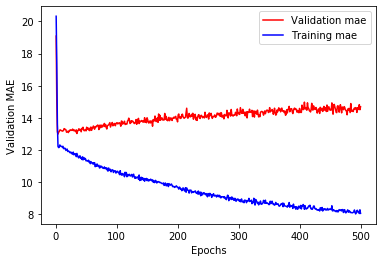

In [180]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_val_history) + 1), average_mae_val_history, 'r', label='Validation mae')
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'b', label='Training mae')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()


#Plotting training and validation loss

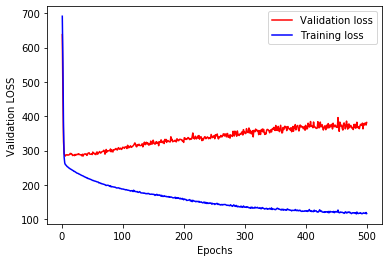

In [182]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_loss_val_history) + 1), average_loss_val_history, 'r', label='Validation loss')
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, 'b', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()